## Monet CycleGAN

This notebook will utilize a CycleGAN to make regular photos more "Monet-esque".  A CycleGAN (Cycle-Consistent Generative Adversarial Network) is a type of deep learning model designed for unsupervised image-to-image translation. It's used to convert images from one domain to another, such as turning photos of horses into photos of zebras or transforming summer landscape images into winter scenes. The "cycle-consistent" part of the name refers to the fact that the model ensures that the translation between domains is reversible, forming a cycle.

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=(RuntimeWarning, FutureWarning, UserWarning))

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from keras.models import Sequential
from keras.layers import Layer, Dense, Activation, Dropout, Input, concatenate, Average, Concatenate, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, LeakyReLU, ZeroPadding2D, GaussianNoise
from keras.optimizers import Adam
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
# AUTOTUNE for parallel data loading
AUTOTUNE = tf.data.experimental.AUTOTUNE

D0820 00:53:39.497700855      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0820 00:53:39.497724969      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0820 00:53:39.497728407      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0820 00:53:39.497731297      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0820 00:53:39.497733822      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0820 00:53:39.497736762      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0820 00:53:39.497740205      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0820 00:53:39.

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local")
    strategy = tf.distribute.TPUStrategy(tpu)
    print("on TPU")
except tf.errors.NotFoundError:
    print("not on TPU")
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

The dataset contains Monet paintings and random photos.  All the images are 256 x 256 and are RGB.  The files contain 300 Monet paintings and 7028 photos.  As recommended in the competition, I followed Amy Jang's notebook "Monet CycleGAN Tutorial" for loading the data from the TFRecords.

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/gan-getting-started


In [4]:
MONET_TFRECORDS_PATH = GCS_PATH + '/monet_tfrec/*.tfrec'
PHOTO_TFRECORDS_PATH = GCS_PATH + '/photo_tfrec/*.tfrec'

# Get TFRecord filenames
MONET_FILENAMES = tf.io.gfile.glob(MONET_TFRECORDS_PATH)
PHOTO_FILENAMES = tf.io.gfile.glob(PHOTO_TFRECORDS_PATH)

# Print the number of TFRecord files for Monet and Photo
print('Monet TFRecord Files:', len(MONET_FILENAMES))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


## EDA

The images are sized to 256 x 256.  The channels while decoding are set to 3 since the images are RGB.  The images are scaled to [-1, 1].

In [5]:
# Define the image size
IMAGE_SIZE = [256, 256]

# Function to decode an image from JPEG format
def decode_jpeg_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# Function to read a single TFRecord example
def read_tfrecord_example(tfrecord_example):
    tfrecord_features = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(tfrecord_example, tfrecord_features)
    decoded_image = decode_jpeg_image(parsed_example['image'])
    return decoded_image

In [6]:
# Function to load a dataset from TFRecord files
def load_tfrecord_dataset(file_paths, include_labels=True, maintain_order=False):
    dataset = tf.data.TFRecordDataset(file_paths)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

# Function to parse a single TFRecord example
def parse_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(example, tfrecord_format)
    decoded_image = decode_jpeg_image(parsed_example['image'])
    return decoded_image

Visualizing a few examples of the Monet paintings and the photos.

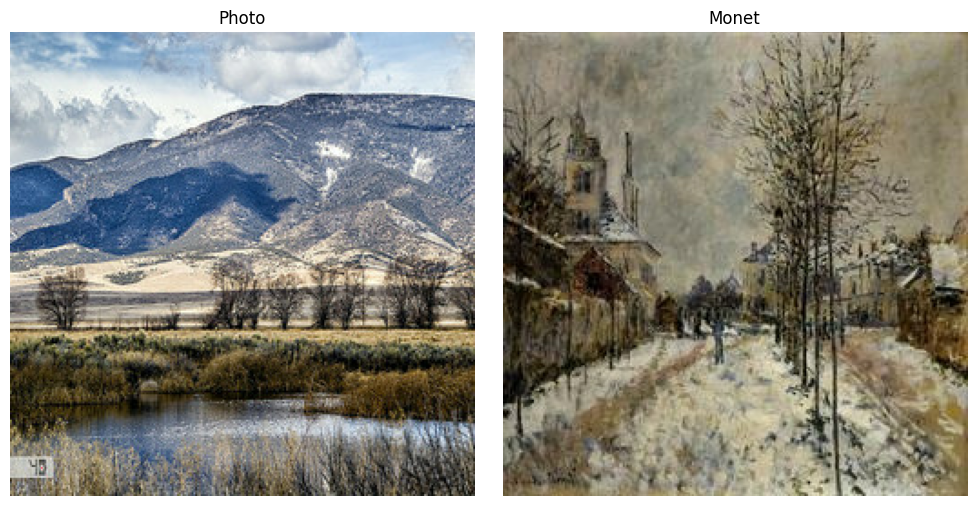

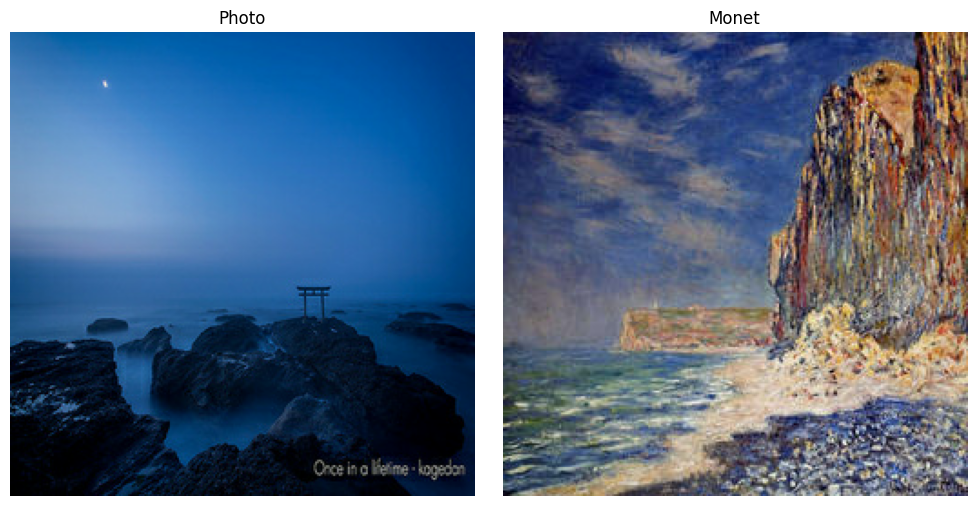

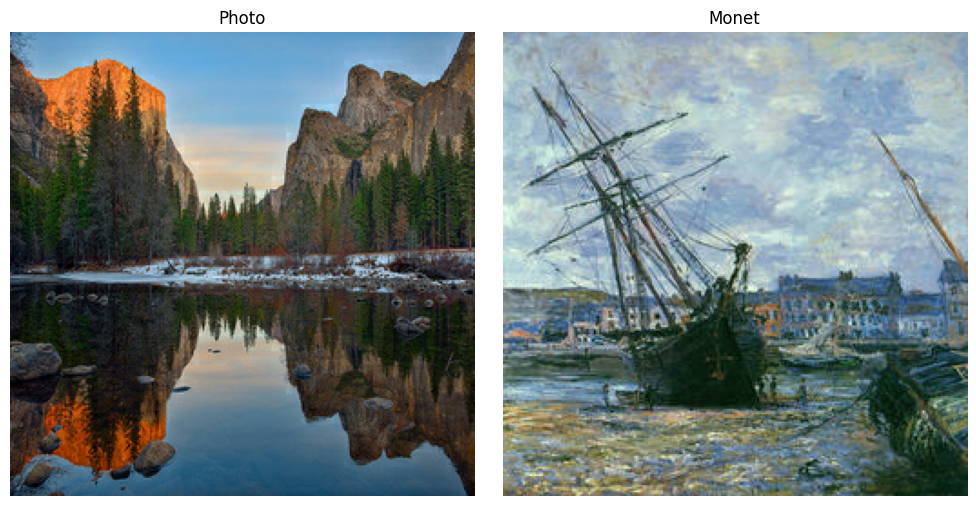

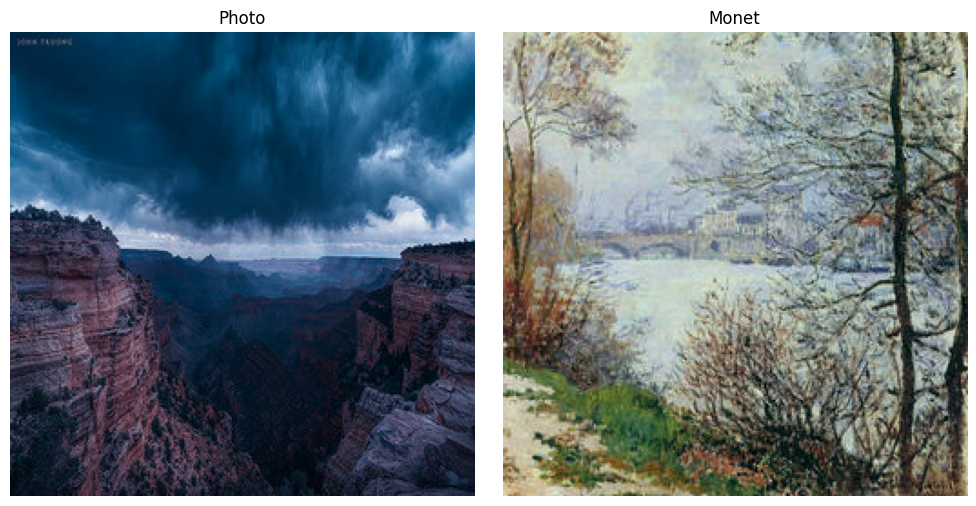

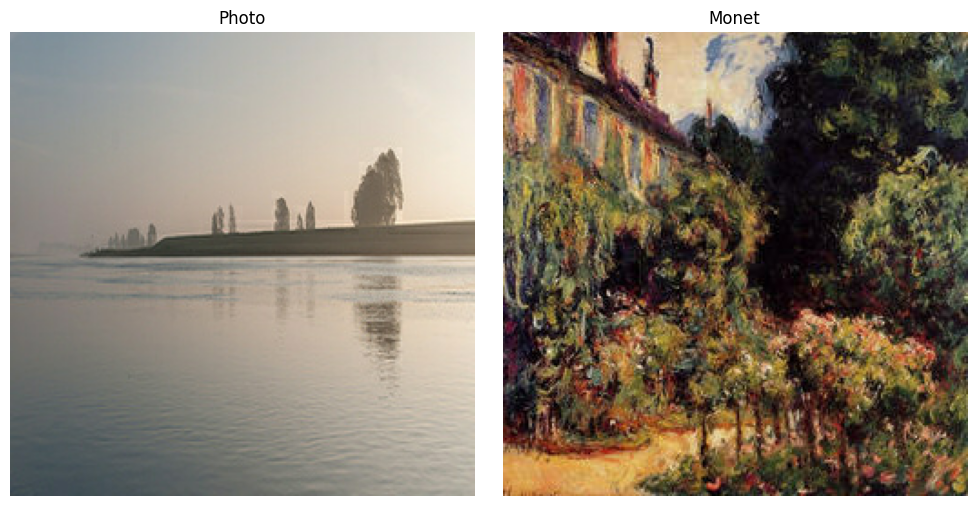

In [7]:
# Load the Monet and Photo datasets
monet_ds = load_tfrecord_dataset(MONET_FILENAMES, include_labels=True).batch(1)
photo_ds = load_tfrecord_dataset(PHOTO_FILENAMES, include_labels=True).batch(1)

# Number of sets to display
num_sets_to_display = 5

# Display different sets of images
for idx, (batch_monet, batch_photo) in enumerate(zip(monet_ds, photo_ds)):
    if idx >= num_sets_to_display:
        break
    
    plt.figure(figsize=(10, 5))

    for i in range(batch_monet.shape[0]):
        plt.subplot(1, 2, 1)
        plt.title('Photo')
        plt.imshow(batch_photo[i] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Monet')
        plt.imshow(batch_monet[i] * 0.5 + 0.5)
        plt.axis('off')

        plt.tight_layout()
    plt.show()

## Modeling

### Downsample

We will begin building the generator by creating the downsample function.

This downsample block is responsible for reducing the spatial dimensions of the input data while increasing the number of channels.  A strided convolution applies the filter with a certain step size (stride) between each position where the filter is applied. This effectively reduces the spatial dimensions of the output. Here we are using a stride of 2 so the output size in each dimension will be halved compared to the input.  The initializers for the convolutional layer's weights and the instance normalization's scaling parameter are Gaussian random initializers with mean 0.0 and standard deviation 0.02.  An optional layer is added to introduce Gaussian noise to the output of the convolutional layer. The standard deviation of this noise is set to 0.2.

$$\text{GaussianNoise}(x) = x + \mathcal{N}(0, \sigma^2)$$

An optional instance normalization layer is added. Instance normalization normalizes the activations of each instance (or sample) in the batch independently. This helps with stabilizing and accelerating training.  After normalization, a Leaky ReLU activation function is applied element-wise to the activations. The Leaky ReLU is defined as:


$$\text{Leaky ReLU}(x) = \begin{cases}
x, & \text{if } x \geq 0 \\
\alpha x, & \text{if } x < 0
\end{cases}$$

Here, alpha is a small positive constant that determines the slope of the function for negative inputs.

In [8]:
# Function to create a downsampling block
def downsample_block(filters, kernel_size, apply_instance_norm=True, add_noise=False):
    conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    gamma_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    block = Sequential()
    block.add(Conv2D(filters, kernel_size, strides=2, padding='same',kernel_initializer=conv_initializer, use_bias=False))
    
    if add_noise:
        result.add(GaussianNoise(0.2))

    if apply_instance_norm:
        block.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer))

    block.add(layers.LeakyReLU())

    return block

# Number of output channels
NUM_OUTPUT_CHANNELS = 3

### Upsample

Next we create the upsample block which increases the spatial dimensions of the input data while reducing the number of channels.Again the initializers for the convolutional layer's weights and the instance normalization's scaling parameter are Gaussian random initializers with mean 0.0 and standard deviation 0.02.  The block starts with a transposed convolutional layer and it performs the opposite of downsampling.  The filters are the number of output channels (feature maps) for this transposed convolutional layer.  The kernel size is the size of the transposed convolutional kernel.  The stride with which the kernel slides over the input. A stride of 2 here means that the output will have double the spatial dimensions of the input, achieving upsampling.  The padding is set to 'same' to ensure that the output dimensions match the desired dimensions.  Similar to the downsampling block, an instance normalization layer is added. It normalizes the activations of each instance (or sample) in the batch independently.  An optional dropout layer is added. Dropout is a regularization technique that randomly sets a fraction of the input units to zero during training. Here, a dropout rate of 0.5 is used.  After normalization and dropout (if applied), a ReLU activation function is applied element-wise to the activations.

$$\text{ReLU}(x) = \max(0, x)$$

In [9]:
# Function to create an upsampling block
def upsample_block(filters, kernel_size, apply_dropout=False):
    conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    gamma_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    block = Sequential()
    block.add(Conv2DTranspose(filters, kernel_size, strides=2, padding='same', kernel_initializer=conv_initializer, use_bias=False))

    block.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer))

    if apply_dropout:
        block.add(Dropout(0.5))

    block.add(ReLU())

    return block

### Generator

Now we define our generator model architecture that uses a series of downsampling and upsampling blocks to transform an input image into an output image in a different domain.  The generator learns to capture and transform the underlying features of the input image while preserving important structural information. 
The input shape is set to (256, 256, 3) representing the shape of the input images (height, width, channels).  A series of downsample blocks are defined using the downsample_block function. These blocks progressively reduce the spatial dimensions and increase the number of channels. Each block captures hierarchical features at different levels of abstraction.  A series of upsample blocks are defined using the upsample_block function. These blocks perform the inverse of downsampling, increasing the spatial dimensions while reducing the number of channels.  The output layer is defined using a Conv2DTranspose layer. It's initialized with a tanh activation function, which maps the output values to the range [-1, 1], suitable for image generation.  The skip connections between corresponding downsampling and upsampling blocks help the model recover fine details and textures in the output image.  The final output is generated by passing the upsampling phase output through the initialized output layer.

In [10]:
# Function to create the generator model
def generator_model():
    input_shape = (256, 256, 3)
    num_downsampling_blocks = 8

    inputs = layers.Input(shape=input_shape)

    # Downsample blocks
    downsampling_blocks = [
        downsample_block(64, 4, apply_instance_norm=False),
        downsample_block(128, 4),
        downsample_block(256, 4),
        downsample_block(512, 4),
        downsample_block(512, 4),
        downsample_block(512, 4),
        downsample_block(512, 4),
        downsample_block(512, 4),
    ]

    # Upsample blocks
    upsampling_blocks = [
        upsample_block(512, 4, apply_dropout=True),
        upsample_block(512, 4, apply_dropout=True),
        upsample_block(512, 4, apply_dropout=True),
        upsample_block(512, 4),
        upsample_block(256, 4),
        upsample_block(128, 4),
        upsample_block(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    output_layer = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs

    # Downsampling
    skip_connections = []
    for down_block in downsampling_blocks:
        x = down_block(x)
        skip_connections.append(x)

    skip_connections = reversed(skip_connections[:-1])

    # Upsampling and skip connections
    for up_block, skip_connection in zip(upsampling_blocks, skip_connections):
        x = up_block(x)
        x = layers.Concatenate()([x, skip_connection])

    output = output_layer(x)

    return keras.Model(inputs=inputs, outputs=output)

### Discriminator

Next we define our discriminator.  The discriminator's role is to classify input images as real or fake, determining if the images come from the true dataset or have been generated by the generator model.\
The input layer is defined with a shape set to (256, 256, 3).  The input is passed through several downsample blocks, which are created using the downsample_block function. Each block reduces the spatial dimensions and increases the number of channels. This simulates the process of the discriminator looking for important features at different scales.  Zero-padding is applied to the feature map.  It involves adding extra border pixels (also called padding) of zeros around the edges of an image or input data. The primary purpose of zero padding is to control the spatial dimensions of the data as it passes through operations like convolutions, without altering the information content.  A convolutional layer with 512 filters, a kernel size of 4x4, and stride 1 is applied to the feature map.  Instance normalization is applied to normalize the activations of each instance.  Leaky ReLU activation is applied to the normalized activations. This activation function introduces non-linearity while allowing small negative values to pass through.  Zero-padding is applied to the activation map once more.  A convolutional layer with 1 filter, a kernel size of 4x4, and stride 1 is applied to produce the final output. The output will have dimensions (batch_size, 30, 30, 1), representing the discriminator's prediction.

In [11]:
def discriminator_model(add_noise=True):
    conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    gamma_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    input_shape = (256, 256, 3)
    inputs = layers.Input(shape=input_shape, name='input_image')

    x = inputs

    x = downsample_block(64, 4, apply_instance_norm=False)(x)  # (bs, 128, 128, 64)
    x = downsample_block(128, 4)(x)  # (bs, 64, 64, 128)
    x = downsample_block(256, 4)(x)  # (bs, 32, 32, 256)

    x = ZeroPadding2D()(x)  # (bs, 34, 34, 256)
    x = Conv2D(512, 4, strides=1, kernel_initializer=conv_initializer, use_bias=False)(x)  # (bs, 31, 31, 512)
    if add_noise:
        x = GaussianNoise(0.2)(x)

    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)

    x = LeakyReLU()(x)

    x = ZeroPadding2D()(x)  # (bs, 33, 33, 512)

    output = Conv2D(1, 4, strides=1, kernel_initializer=conv_initializer)(x)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inputs, outputs=output)

### CycleGAN Model

Now we define the cycleGan model class to be used in conjunction with the TensorFlow/Keras training loop to train a CycleGAN model for specific image translation tasks.  It involves training two generators to translate images between two domains, and two discriminators to distinguish between real and fake images. The losses include generator loss (adversarial loss), cycle consistency loss (to ensure that translating back and forth between domains reconstructs the original image), and identity loss (to ensure that an image remains unchanged when translated and then translated back). The method train_step encapsulates the entire training process for a single batch of data.

In [16]:
class CycleGAN(keras.Model):
    def __init__(self, monet_generator, photo_generator,
                 monet_discriminator, photo_discriminator,
                 lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.monet_generator = monet_generator
        self.photo_generator = photo_generator
        self.monet_discriminator = monet_discriminator
        self.photo_discriminator = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self, monet_gen_optimizer, photo_gen_optimizer,
                monet_disc_optimizer, photo_disc_optimizer,
                generator_loss_fn, discriminator_loss_fn,
                cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.monet_gen_optimizer = monet_gen_optimizer
        self.photo_gen_optimizer = photo_gen_optimizer
        self.monet_disc_optimizer = monet_disc_optimizer
        self.photo_disc_optimizer = photo_disc_optimizer
        self.generator_loss_fn = generator_loss_fn
        self.discriminator_loss_fn = discriminator_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Photo to Monet back to Photo
            fake_monet = self.monet_generator(real_photo, training=True)
            cycled_photo = self.photo_generator(fake_monet, training=True)

            # Monet to Photo back to Monet
            fake_photo = self.photo_generator(real_monet, training=True)
            cycled_monet = self.monet_generator(fake_photo, training=True)

            # Generating itself
            same_monet = self.monet_generator(real_monet, training=True)
            same_photo = self.photo_generator(real_photo, training=True)

            # Discriminator for real images
            disc_real_monet = self.monet_discriminator(real_monet, training=True)
            disc_real_photo = self.photo_discriminator(real_photo, training=True)

            # Discriminator for fake images
            disc_fake_monet = self.monet_discriminator(fake_monet, training=True)
            disc_fake_photo = self.photo_discriminator(fake_photo, training=True)

            # Generator loss
            monet_gen_loss = self.generator_loss_fn(disc_fake_monet)
            photo_gen_loss = self.generator_loss_fn(disc_fake_photo)

            # Total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Discriminator loss
            monet_disc_loss = self.discriminator_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.discriminator_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate gradients
        monet_gen_gradients = tape.gradient(total_monet_gen_loss, self.monet_generator.trainable_variables)
        photo_gen_gradients = tape.gradient(total_photo_gen_loss, self.photo_generator.trainable_variables)
        monet_disc_gradients = tape.gradient(monet_disc_loss, self.monet_discriminator.trainable_variables)
        photo_disc_gradients = tape.gradient(photo_disc_loss, self.photo_discriminator.trainable_variables)

        # Apply gradients
        self.monet_gen_optimizer.apply_gradients(zip(monet_gen_gradients, self.monet_generator.trainable_variables))
        self.photo_gen_optimizer.apply_gradients(zip(photo_gen_gradients, self.photo_generator.trainable_variables))
        self.monet_disc_optimizer.apply_gradients(zip(monet_disc_gradients, self.monet_discriminator.trainable_variables))
        self.photo_disc_optimizer.apply_gradients(zip(photo_disc_gradients, self.photo_discriminator.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Loss Functions

Next we define our loss functions

1.  Binary Cross_Entropy Loss
* This is a standard loss function used for binary classification problems, here the discriminator's goal is to classify between real and fake samples.
$$\text{BCE}(y, \hat{y}) = - y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})$$

2.  Discriminator Loss
* This function calculates the adversarial loss for the discriminator. It compares the discriminator's predictions for real images and generated images.
$$\text{DiscriminatorLoss}(D, G) = \frac{1}{2} \left( \text{BCE}(1, D(x)) + \text{BCE}(0, D(G(z))) \right)$$

3.  Generator Loss
* This function calculates the adversarial loss for the generator. It aims to make the generated images indistinguishable from real images by encouraging the generator to produce images that the discriminator classifies as real.
$$\text{GeneratorLoss}(G) = \text{BCE}(1, D(G(z)))$$

4.  Cycle Consistency Loss
* This loss enforces the cycle consistency property of the CycleGAN. It measures the difference between the original image and the image reconstructed after translation and back translation.
$$\text{CycleLoss}(x, G, F, \lambda) = \lambda \cdot \frac{1}{N} \sum_{i=1}^{N} \| x_i - F(G(x_i)) \|_1$$

5.  Identity Loss
* This loss encourages the generator to maintain the content of an image when it is translated and then translated back (identity mapping). It measures the difference between the original image and the image after translation and back translation.
$$\text{IdentityLoss}(x, G, \lambda) = \lambda \cdot \frac{1}{N} \sum_{i=1}^{N} \| x_i - G(x_i) \|_1$$

* $y$ represents the target label (0 for fake, 1 for real).
* $\hat{y}$ represents the predicted output (probability) from the discriminator.
* $D(x)$ represents the discriminator's prediction for a real image $x$.

In [17]:
# Define loss functions
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

def discriminator_loss(real, generated):
    real_loss = bce_loss(tf.ones_like(real), real)
    generated_loss = bce_loss(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return bce_loss(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Apply strategy.scope() to the defined loss functions
with strategy.scope():
    discriminator_loss = tf.function(discriminator_loss)
    generator_loss = tf.function(generator_loss)
    calc_cycle_loss = tf.function(calc_cycle_loss)
    identity_loss = tf.function(identity_loss)

### Training the CycleGAN

In [14]:
# Define optimizer
#optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

with strategy.scope():
    monet_generator = generator_model() # transforms photos to Monet-esque paintings
    photo_generator = generator_model() # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_model() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_model() # differentiates real photos and generated photos

with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Create CycleGAN model
with strategy.scope():
    cycle_gan_model = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
    cycle_gan_model.compile(
        monet_gen_optimizer=monet_generator_optimizer,
        photo_gen_optimizer=photo_generator_optimizer,
        monet_disc_optimizer=monet_discriminator_optimizer,
        photo_disc_optimizer=photo_discriminator_optimizer,
        generator_loss_fn=generator_loss,
        discriminator_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

# Fit the model
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)

Epoch 1/20


2023-08-20 00:56:09.982387: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-20 00:56:11.756049: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 [==============================] - 165s 135ms/step - monet_gen_loss: 5.4000 - photo_gen_loss: 5.4972 - monet_disc_loss: 0.6400 - photo_disc_loss: 0.6425
Epoch 2/20
300/300 [==============================] - 40s 134ms/step - monet_gen_loss: 3.7147 - photo_gen_loss: 3.7124 - monet_disc_loss: 0.6310 - photo_disc_loss: 0.6283
Epoch 3/20
300/300 [==============================] - 40s 133ms/step - monet_gen_loss: 3.6130 - photo_gen_loss: 3.6253 - monet_disc_loss: 0.6169 - photo_disc_loss: 0.6224
Epoch 4/20
300/300 [==============================] - 40s 134ms/step - monet_gen_loss: 3.5092 - photo_gen_loss: 3.5524 - monet_disc_loss: 0.6234 - photo_disc_loss: 0.6047
Epoch 5/20
300/300 [==============================] - 40s 133ms/step - monet_gen_loss: 3.3271 - photo_gen_loss: 3.4029 - monet_disc_loss: 0.6163 - photo_disc_loss: 0.5881
Epoch 6/20
300/300 [==============================] - 40s 133ms/step - monet_gen_loss: 3.2491 - photo_gen_loss: 3.3288 - monet_disc_loss: 0.6089 - photo_di

In [18]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)

Epoch 1/20
300/300 [==============================] - 40s 133ms/step - monet_gen_loss: 2.8812 - photo_gen_loss: 3.0362 - monet_disc_loss: 0.6090 - photo_disc_loss: 0.5787
Epoch 2/20
300/300 [==============================] - 40s 133ms/step - monet_gen_loss: 2.6442 - photo_gen_loss: 2.8876 - monet_disc_loss: 0.6607 - photo_disc_loss: 0.6069
Epoch 3/20
300/300 [==============================] - 40s 133ms/step - monet_gen_loss: 2.6645 - photo_gen_loss: 2.8986 - monet_disc_loss: 0.6529 - photo_disc_loss: 0.6047
Epoch 4/20
300/300 [==============================] - 40s 134ms/step - monet_gen_loss: 2.5872 - photo_gen_loss: 2.7972 - monet_disc_loss: 0.6586 - photo_disc_loss: 0.6251
Epoch 5/20
300/300 [==============================] - 40s 133ms/step - monet_gen_loss: 2.5376 - photo_gen_loss: 2.7193 - monet_disc_loss: 0.6606 - photo_disc_loss: 0.6229
Epoch 6/20
300/300 [==============================] - 40s 133ms/step - monet_gen_loss: 2.4885 - photo_gen_loss: 2.7120 - monet_disc_loss: 0.6644 

### Training Loss

Taking a look at the losses we can see that they don't look to be instable or show any signs of generator collapse.

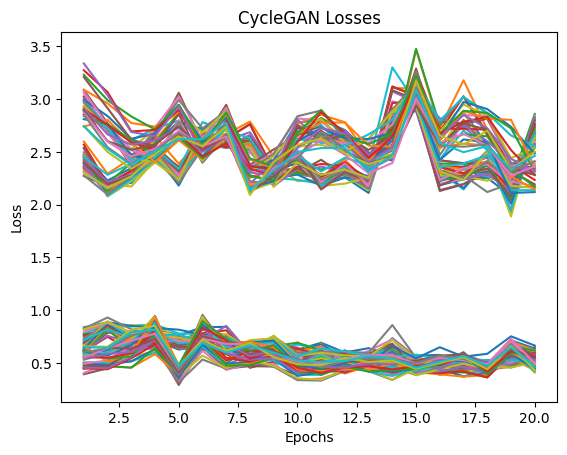

In [32]:
monet_gen_loss = [epoch_loss[0][0] for epoch_loss in history.history['monet_gen_loss']]
photo_gen_loss = [epoch_loss[0][0] for epoch_loss in history.history['photo_gen_loss']]
monet_disc_loss = [epoch_loss[0][0] for epoch_loss in history.history['monet_disc_loss']]
photo_disc_loss = [epoch_loss[0][0] for epoch_loss in history.history['photo_disc_loss']]

# Now you can plot the loss values
plt.plot(range(1, len(monet_gen_loss) + 1), monet_gen_loss, label='Monet Generator Loss')
plt.plot(range(1, len(photo_gen_loss) + 1), photo_gen_loss, label='Photo Generator Loss')
plt.plot(range(1, len(monet_disc_loss) + 1), monet_disc_loss, label='Monet Discriminator Loss')
plt.plot(range(1, len(photo_disc_loss) + 1), photo_disc_loss, label='Photo Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CycleGAN Losses')
plt.show()

### Hyperparameter Tuning

I didn't tune the model in the traditional sense by looping through various hyperparameters.  I took more of an approach of selecting hyperparameters based on the literature and what seemed to work best for other people.  Leaky ReLU for downsample and discriminator, ReLU for upsample, and TanH for the generator were popular choices.  Increasing the number of down and upsample blocks seemd to produce more blurry images.  Increasing the learning rate didn't improve the results.

### Visualize the Monet-esque Photos

Looking at a few of the photos, some of them seem to look more "Monet-esque" than others.  The images that have a slight pixelated look do seem like an Impressionist painting but some are too pixelated.  Since GANs don't produce an accuracy, imterpreting the model's results is subjective.

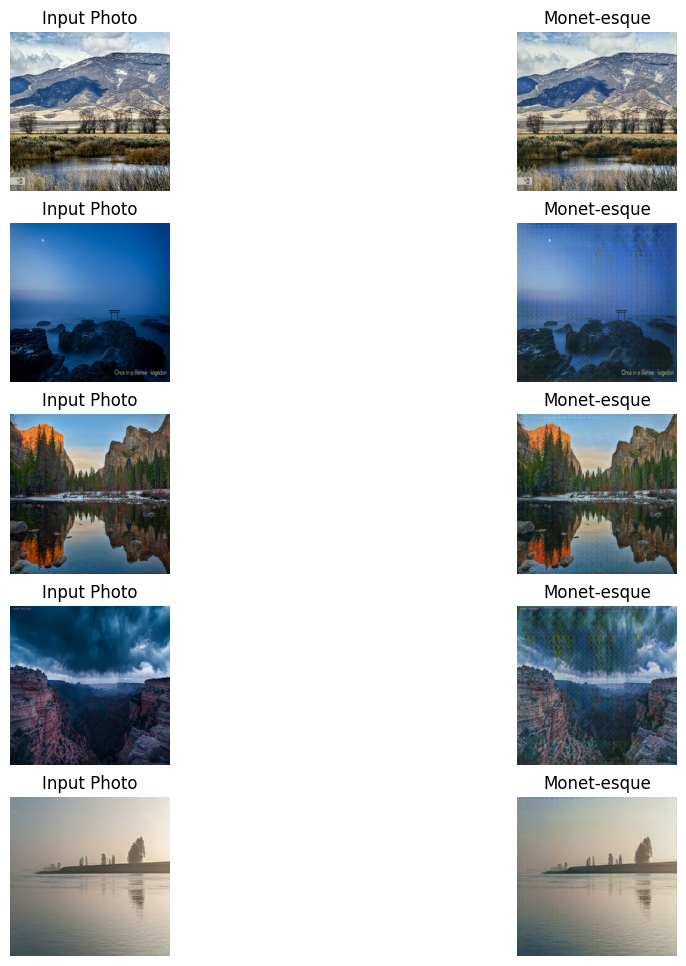

In [34]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Submission

Exporting the file for Kaggle competition.  The submissions are evaluated on MiFID (Memorization-informed Fréche Inception Distance).  The smaller the MiFID is, the better the generated images are.

In [35]:
import PIL
! mkdir ../images

In [36]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [37]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

### Conclusions
The score from kaggle evaluated on MiFID was a 68.9 which was pretty decent when comparing to the other scores on the leader board so I was happy about it.  The training was stable and I never saw any mode collapse.  Given some more time I would like to experiment with the model architecture.  GANs were very new to me coming into this project but I'm looking forward to experimenting with them more in the future.


### References

Jang, Amy (2020).  Monet CycleGAN Tutorial. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

Nesterov, Andrey (2023).  Monet: CycleGAN with Better Cycles.  https://www.kaggle.com/code/andreynesterov/monet-cyclegan-with-better-cycles

Apply Generative Adversarial Networks (GANs). Deeplearning.ai

https://www.coursera.org/learn/apply-generative-adversarial-networks-gans?specialization=generative-adversarial-networks-gans